# Control cinemático de un robot RP
Iniciamos recordando las ecuaciones de la cinemática directa:
$$x=(L_1+\theta_2)cos(\theta_1)$$
$$y=(L_1+\theta_2)sin(\theta_1)$$

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def RP_fkine(theta1,theta2,L1):
  x = (L1 + theta2) * np.cos(theta1)
  y = (L1 + theta2) * np.sin(theta1)
  return np.array([[x],[y]])

RP_fkine(0,1,2)

array([[3.],
       [0.]])

Ahora construimos su matriz Jacobiana:

$$J=
\begin{bmatrix}
\frac{\partial x}{\partial \theta_1} &
\frac{\partial x}{\partial \theta_2} \\
\frac{\partial y}{\partial \theta_1} &
\frac{\partial y}{\partial \theta_2}
\end{bmatrix}
$$

$$J=
\begin{bmatrix}
-(L_1+\theta_2)sin(\theta_1) &
cos(\theta_1) \\
(L_1+\theta_2)cos(\theta_1) &
sin(\theta_1)
\end{bmatrix}
$$

O también la podemos obtener simbólicamente:

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

theta1, theta2, L1 = sp.symbols('theta1 theta2 L1')
x = (L1 + theta2) * sp.cos(theta1)
y = (L1 + theta2) * sp.sin(theta1)
omega1, omega2 = sp.symbols('omega1 omega2')
f = sp.Matrix([[x],[y]])
J = f.jacobian([theta1, theta2])
J

Matrix([
[-(L1 + theta2)*sin(theta1), cos(theta1)],
[ (L1 + theta2)*cos(theta1), sin(theta1)]])

In [3]:
def J_RP(theta1,theta2,L1):
  J = np.array([[-np.sin(theta1)*(L1+theta2),np.cos(theta1)],[np.cos(theta1)*(L1+theta2),np.sin(theta1)]])
  return

Con esta matriz, podemos obtener la velocidad en espacio de la tarea de nuestro manipulador a partir de la velocidad en el espacio articular:
$$\begin{bmatrix}\dot{x}\\\dot{y}\end{bmatrix} = J(\theta_1,\theta_2)\begin{bmatrix}\dot{\theta_1}\\\dot{\theta_2}\end{bmatrix}= J(\theta_1,\theta_2)\begin{bmatrix}\omega_1\\\omega_2\end{bmatrix}$$

In [4]:
xp = J*sp.Matrix([[omega1],[omega2]])
xp

Matrix([
[-omega1*(L1 + theta2)*sin(theta1) + omega2*cos(theta1)],
[ omega1*(L1 + theta2)*cos(theta1) + omega2*sin(theta1)]])

In [5]:
v1 = xp.subs({L1:3, theta1:sp.pi/4, theta2:2,omega1:sp.pi/8,omega2:4})
v1

Matrix([
[-5*sqrt(2)*pi/16 + 2*sqrt(2)],
[ 5*sqrt(2)*pi/16 + 2*sqrt(2)]])

In [6]:
xpn = sp.lambdify((theta1,theta2,omega1,omega2,L1),xp,modules="numpy")
xpn(np.pi/4,2,np.pi/8,4,3)
Jn = sp.lambdify((theta1,theta2,L1),J,modules="numpy")
Jn(np.pi/4,2,3)

array([[-3.53553391,  0.70710678],
       [ 3.53553391,  0.70710678]])

# Control cinemático

$$\dot{x} = J\omega$$

Yo puedo fijar $\omega$ a lo que yo quiera, si $J$ es invertible entonces puedo fijarlo a:
$$\omega = J^{-1}(\dot{x_d}-K_p(x_d-x))$$




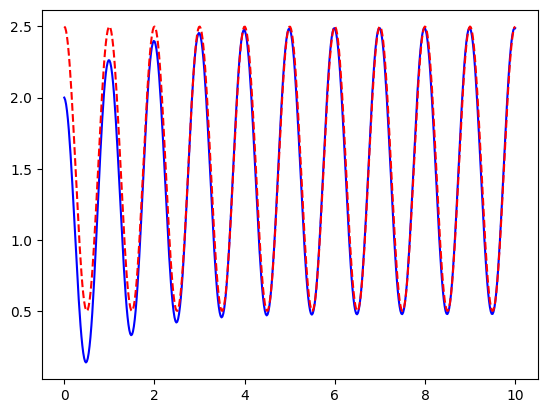

In [7]:
t = np.linspace(0,10,500)
dt = t[1] - t[0]
xd = 1.5+np.cos(2*np.pi*t)
yd = 3.5+np.sin(2*np.pi*t)
Xd = np.stack([xd,yd])
xdp = -2*np.pi*np.sin(2*np.pi*t)
ydp =  2*np.pi*np.cos(2*np.pi*t)
Vd = np.stack([xdp,ydp])

L1 = 2
Kp = 1;

theta = np.zeros([2,len(t)])
X = np.zeros([2,len(t)])

theta[:,0] = [0, 0]
X[:,0] = np.stack([(L1 + theta[1,0]) * np.cos(theta[0,0]), (L1 + theta[1,0]) * np.sin(theta[0,0])])
for i in range(1,len(t)):
  Jinv = np.linalg.inv(Jn(theta[0,i-1],theta[1,i-1],L1))
  omega_d = Jinv@(Vd[:,i] + Kp*(Xd[:,i]-X[:,i-1]))
  theta[:,i] = theta[:,i-1] + omega_d*dt
  X[:,i] = np.stack([(L1 + theta[1,i]) * np.cos(theta[0,i]), (L1 + theta[1,i]) * np.sin(theta[0,i])])

plt.plot(t,X[0,:],'b')
plt.plot(t,Xd[0,:],'r--')

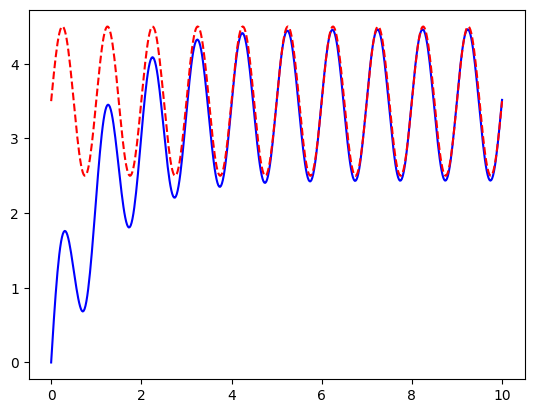

In [8]:
plt.plot(t,X[1,:],'b')
plt.plot(t,Xd[1,:],'r--')

In [ ]:
# @title Animación RP con tramas RGB, trayectoria deseada y rastro
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_RP(theta, X, Xd, t, L1, axis_len=0.5, trail=True, skip=2):
    """
    Anima un manipulador planar RP:
      - q1: rotacional (ángulo del primer eslabón respecto a la base)
      - q2: prismático (extensión radial a lo largo del eje x de la trama de la junta 1)
      - Cinemática usada en tu simulación:
          O2 = [(L1 + q2) cos(q1), (L1 + q2) sin(q1)]
          O1 = [ L1 cos(q1),        L1 sin(q1)       ]
      - Eslabones en negro
      - Tramas RGB en base, junta 1 y efector final
      - Trayectoria deseada (Xd) y rastro del EE (X)

    Parámetros:
      theta: 2xN con [q1; q2]
      X:     2xN posiciones alcanzadas (x,y) del EE
      Xd:    2xN posiciones deseadas
      t:     vector de tiempo (N,)
      L1:    longitud fija del primer tramo
      axis_len: longitud visual de ejes locales
      trail: dibuja rastro si True
      skip:  muestra 1 de cada 'skip' pasos (aligerar animación)
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title('RP planar — eslabones (negro), tramas RGB, trayectoria y rastro')

    # Límites del gráfico a partir de X, Xd y del radio L1 +/- |q2|
    margin = 0.6
    r_inst = L1 + theta[1, :]
    xO2 = r_inst * np.cos(theta[0, :])
    yO2 = r_inst * np.sin(theta[0, :])
    x_all = np.concatenate([Xd[0], X[0], xO2, np.array([0.0])])
    y_all = np.concatenate([Xd[1], X[1], yO2, np.array([0.0])])
    ax.set_xlim(np.min(x_all) - margin, np.max(x_all) + margin)
    ax.set_ylim(np.min(y_all) - margin, np.max(y_all) + margin)

    # Trayectoria deseada y rastro
    desired_line, = ax.plot(Xd[0], Xd[1], '--', linewidth=1.5, label='Trayectoria deseada')
    trail_line,   = ax.plot([], [], ':',  linewidth=1.8, label='Rastro (alcanzado)')

    # Eslabones
    link1_line, = ax.plot([], [], 'k-', linewidth=3)  # O0 -> O1
    link2_line, = ax.plot([], [], 'k-', linewidth=3)  # O1 -> O2
    ee_point,   = ax.plot([], [], 'o', markersize=5)

    # Tramas RGB (x rojo, y verde) + punto azul en cada origen
    f0_x, = ax.plot([], [], '-', linewidth=2, color='r')
    f0_y, = ax.plot([], [], '-', linewidth=2, color='g')
    f1_x, = ax.plot([], [], '-', linewidth=2, color='r')
    f1_y, = ax.plot([], [], '-', linewidth=2, color='g')
    f2_x, = ax.plot([], [], '-', linewidth=2, color='r')
    f2_y, = ax.plot([], [], '-', linewidth=2, color='g')
    base_dot,  = ax.plot([], [], 'o', markersize=4, color='b')
    joint_dot, = ax.plot([], [], 'o', markersize=4, color='b')
    ee_dot,    = ax.plot([], [], 'o', markersize=4, color='b')

    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    ax.legend(loc='upper right')

    def frame_axes(origin, angle):
        """Devuelve puntos para dibujar ejes locales x,y de longitud axis_len."""
        c, s = np.cos(angle), np.sin(angle)
        x_axis = np.array([c, s])
        y_axis = np.array([-s, c])
        p = np.array(origin)
        return p, p + axis_len*x_axis, p + axis_len*y_axis

    def init():
        trail_line.set_data([], [])
        link1_line.set_data([], [])
        link2_line.set_data([], [])
        ee_point.set_data([], [])
        for ln in (f0_x, f0_y, f1_x, f1_y, f2_x, f2_y):
            ln.set_data([], [])
        for dot in (base_dot, joint_dot, ee_dot):
            dot.set_data([], [])
        time_text.set_text('')
        return (link1_line, link2_line, ee_point, trail_line,
                f0_x, f0_y, f1_x, f1_y, f2_x, f2_y,
                base_dot, joint_dot, ee_dot, time_text)

    def update(k):
        idx = min(k * skip, t.size - 1)
        q1 = theta[0, idx]  # ángulo
        q2 = theta[1, idx]  # extensión prismatic

        # Orígenes de tramas
        O0 = np.array([0.0, 0.0])
        O1 = np.array([L1*np.cos(q1), L1*np.sin(q1)])
        O2 = np.array([(L1 + q2)*np.cos(q1), (L1 + q2)*np.sin(q1)])

        # Eslabones
        link1_line.set_data([O0[0], O1[0]], [O0[1], O1[1]])
        link2_line.set_data([O1[0], O2[0]], [O1[1], O2[1]])

        # Rastro y punto EE
        if trail:
            trail_line.set_data(X[0, :idx+1], X[1, :idx+1])
        ee_point.set_data([O2[0]], [O2[1]])

        # Tramas RGB
        # Base (ángulo 0)
        p0, p0x, p0y = frame_axes(O0, 0.0)
        f0_x.set_data([p0[0], p0x[0]], [p0[1], p0x[1]])
        f0_y.set_data([p0[0], p0y[0]], [p0[1], p0y[1]])
        base_dot.set_data([O0[0]], [O0[1]])

        # Junta 1 (ángulo q1)
        p1, p1x, p1y = frame_axes(O1, q1)
        f1_x.set_data([p1[0], p1x[0]], [p1[1], p1x[1]])
        f1_y.set_data([p1[0], p1y[0]], [p1[1], p1y[1]])
        joint_dot.set_data([O1[0]], [O1[1]])

        # Efector final (ángulo q1, prismatico a lo largo de x local)
        p2, p2x, p2y = frame_axes(O2, q1)
        f2_x.set_data([p2[0], p2x[0]], [p2[1], p2x[1]])
        f2_y.set_data([p2[0], p2y[0]], [p2[1], p2y[1]])
        ee_dot.set_data([O2[0]], [O2[1]])

        time_text.set_text(f't = {t[idx]:.2f} s')

        return (link1_line, link2_line, ee_point, trail_line,
                f0_x, f0_y, f1_x, f1_y, f2_x, f2_y,
                base_dot, joint_dot, ee_dot, time_text)

    interval_ms = max(10, int((t[1] - t[0]) * 1000))
    frames = int(np.ceil(t.size / skip))
    anim = FuncAnimation(fig, update, frames=frames, init_func=init,
                         blit=True, interval=interval_ms)
    plt.close(fig)
    return anim

# Ejecutar la animación (usa to_jshtml para un render ligero en Colab/Jupyter)
anim = animate_RP(theta, X, Xd, t, L1, axis_len=0.5, trail=True, skip=2)
HTML(anim.to_jshtml())
